In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
import keras_tuner as kt

In [ ]:

# %%
# Paths
large_train = "../424_F2024_Final_PC_large_train_v1.csv"
test_path = "../424_F2024_Final_PC_test_without_response_v1.csv"
model_path = "my_improved_model.h5"

df_train = pd.read_csv(large_train)
df_test = pd.read_csv(test_path)

# Basic NLTK setup
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
sid = SentimentIntensityAnalyzer()

def clean_text(text):
    if pd.isnull(text):
        return 'Unknown'
    text = text.encode('ascii', 'ignore').decode()  
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower().strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

def extract_sentiment_scores(text):
    # If text is empty or 'Unknown', handle gracefully
    if text.strip() == '' or text == 'Unknown':
        return {'neg':0, 'neu':0, 'pos':0, 'compound':0}
    scores = sid.polarity_scores(text)
    return scores

def preprocess_data(df_train, df_test):
    for col in ['pros', 'cons', 'headline']:
        df_train[col] = df_train[col].apply(clean_text)
        df_test[col] = df_test[col].apply(clean_text)

    # Combine text columns
    combined_text_train = df_train['pros'] + " " + df_train['cons'] + " " + df_train['headline']
    combined_text_test = df_test['pros'] + " " + df_test['cons'] + " " + df_test['headline']

    # Tfidf with more features
    tfidf_vectorizer = TfidfVectorizer(max_features=3000)  # Increased from 1000
    combined_tfidf_train = tfidf_vectorizer.fit_transform(combined_text_train).toarray()
    combined_tfidf_test = tfidf_vectorizer.transform(combined_text_test).toarray()

    # Extract sentiment features from the combined text
    train_sentiment = pd.DataFrame([extract_sentiment_scores(t) for t in combined_text_train])
    test_sentiment = pd.DataFrame([extract_sentiment_scores(t) for t in combined_text_test])

    # Handle missing categorical data
    df_train['job_title'] = df_train['job_title'].fillna('Unknown')
    df_test['job_title'] = df_test['job_title'].fillna('Unknown')
    df_train['firm'] = df_train['firm'].fillna('Unknown')
    df_test['firm'] = df_test['firm'].fillna('Unknown')

    # Label encode firm
    label_encoder_firm = LabelEncoder()
    all_firm_values = pd.concat([df_train['firm'], df_test['firm']])
    label_encoder_firm.fit(all_firm_values)
    df_train['firm_encoded'] = label_encoder_firm.transform(df_train['firm'])
    df_test['firm_encoded'] = label_encoder_firm.transform(df_test['firm'])

    # Target
    y_train = df_train['rating'].values
    y_test = df_test['rating'].values

    # Stack features
    X_train = np.hstack([combined_tfidf_train,
                         df_train[['firm_encoded']].values,
                         train_sentiment[['neg','neu','pos','compound']].values
                         ]).astype('float32')

    X_test = np.hstack([combined_tfidf_test,
                        df_test[['firm_encoded']].values,
                        test_sentiment[['neg','neu','pos','compound']].values
                        ]).astype('float32')

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = preprocess_data(df_train, df_test)

# %%
# Hyperparameter tuning with Keras Tuner
def build_model(hp):
    model = Sequential()
    # Tune number of units in the first Dense layer
    model.add(Dense(units=hp.Int('units_1', min_value=128, max_value=512, step=64),
                    input_dim=X_train.shape[1], kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.5, step=0.1)))

    # Second layer
    model.add(Dense(units=hp.Int('units_2', min_value=64, max_value=256, step=64),
                    kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    # Third layer
    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=128, step=32),
                    kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.3, step=0.1)))

    # Final output layer
    model.add(Dense(1, activation='linear'))

    # Tune the learning rate for Adam
    lr = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mean_squared_error',
                  metrics=['mse'])
    return model

# Set up K-Fold for more robust training evaluation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
val_scores = []

# Using a subset of data for tuning to speed up
X_tune, X_hold, y_tune, y_hold = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

tuner = kt.RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=5,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='rating_prediction'
)

early_stopping = EarlyStopping(monitor='val_mse', patience=20, restore_best_weights=True)

tuner.search(X_tune, y_tune, validation_split=0.2, epochs=50, callbacks=[early_stopping], verbose=2)
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

# Build the best model
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping, ReduceLROnPlateau(monitor='val_mse', factor=0.5, patience=10, min_lr=1e-5)],
    verbose=2
)

best_model.save(model_path)


Trial 5 Complete [00h 28m 05s]
val_mse: 0.723732054233551

Best val_mse So Far: 0.7091707587242126
Total elapsed time: 01h 19m 18s
Best Hyperparameters:
units_1: 128
dropout_1: 0.5
units_2: 256
dropout_2: 0.1
units_3: 96
dropout_3: 0.1
learning_rate: 0.0005
Epoch 1/100
6250/6250 - 14s - loss: 1.5585 - mse: 1.0852 - val_loss: 1.1004 - val_mse: 0.7267 - lr: 5.0000e-04 - 14s/epoch - 2ms/step
Epoch 2/100
6250/6250 - 13s - loss: 1.0750 - mse: 0.7931 - val_loss: 0.9157 - val_mse: 0.7075 - lr: 5.0000e-04 - 13s/epoch - 2ms/step
Epoch 3/100
6250/6250 - 13s - loss: 0.9461 - mse: 0.7695 - val_loss: 0.8740 - val_mse: 0.7176 - lr: 5.0000e-04 - 13s/epoch - 2ms/step
Epoch 4/100
6250/6250 - 13s - loss: 0.9086 - mse: 0.7600 - val_loss: 0.8510 - val_mse: 0.7081 - lr: 5.0000e-04 - 13s/epoch - 2ms/step
Epoch 5/100
6250/6250 - 12s - loss: 0.8924 - mse: 0.7540 - val_loss: 0.8427 - val_mse: 0.7089 - lr: 5.0000e-04 - 12s/epoch - 2ms/step
Epoch 6/100
6250/6250 - 12s - loss: 0.8830 - mse: 0.7496 - val_loss: 0.8

ValueError: Input contains NaN.

In [8]:
from tensorflow.keras.models import load_model

model = load_model(model_path) 

In [9]:
# Evaluate on training data
y_pred_train = model.predict(X_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print(f"Training MSE: {mse_train}")
print(f"Training R-squared: {r2_train}")


15625/15625 [==============================] - 8s 510us/step
Training MSE: 0.5966403155769171
Training R-squared: 0.5150675583862495


In [ ]:
# Predictions on test data
y_pred_test = model.predict(X_test)

3125/3125 [==============================] - 1s 475us/step


In [12]:
y_pred_test

array([[4.549068 ],
       [4.0479784],
       [4.8657446],
       ...,
       [3.341823 ],
       [3.1941707],
       [4.795516 ]], dtype=float32)

In [13]:
# Step 1: Define your information
student_id = '20952031' 
anonymized_name = '808' 
prediction_accuracy = r2_train  
algorithm_name = 'Neural Network Model' 

data = [
    [student_id],
    [anonymized_name],
    [prediction_accuracy],
    [algorithm_name]
] + [pred for pred in y_pred_test]


df = pd.DataFrame(data)

df.to_csv('learn_improved_model_perdictions.csv', header=False, index=False)

print("CSV file created successfully.")

CSV file created successfully.


In [14]:
# Create the Kaggle-style DataFrame
y_data_kaggle = []
for pred in y_pred_test:
    for val in pred:
        y_data_kaggle.append(val)

data = {
    "ID_num": range(1, len(y_data_kaggle) + 1),
    "prediction": y_data_kaggle
}

df = pd.DataFrame(data)

# Save to CSV
df.to_csv('kaggle_improved_perdictions.csv', index=False)

print("CSV file created successfully in Kaggle format.")

CSV file created successfully in Kaggle format.


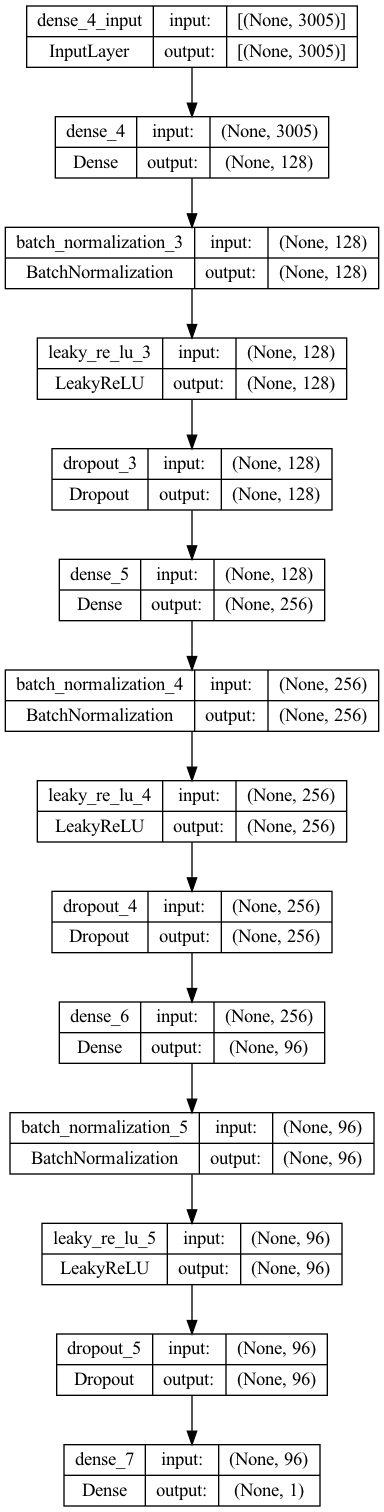

In [15]:
from keras.utils import plot_model

# Visualize model architecture
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)

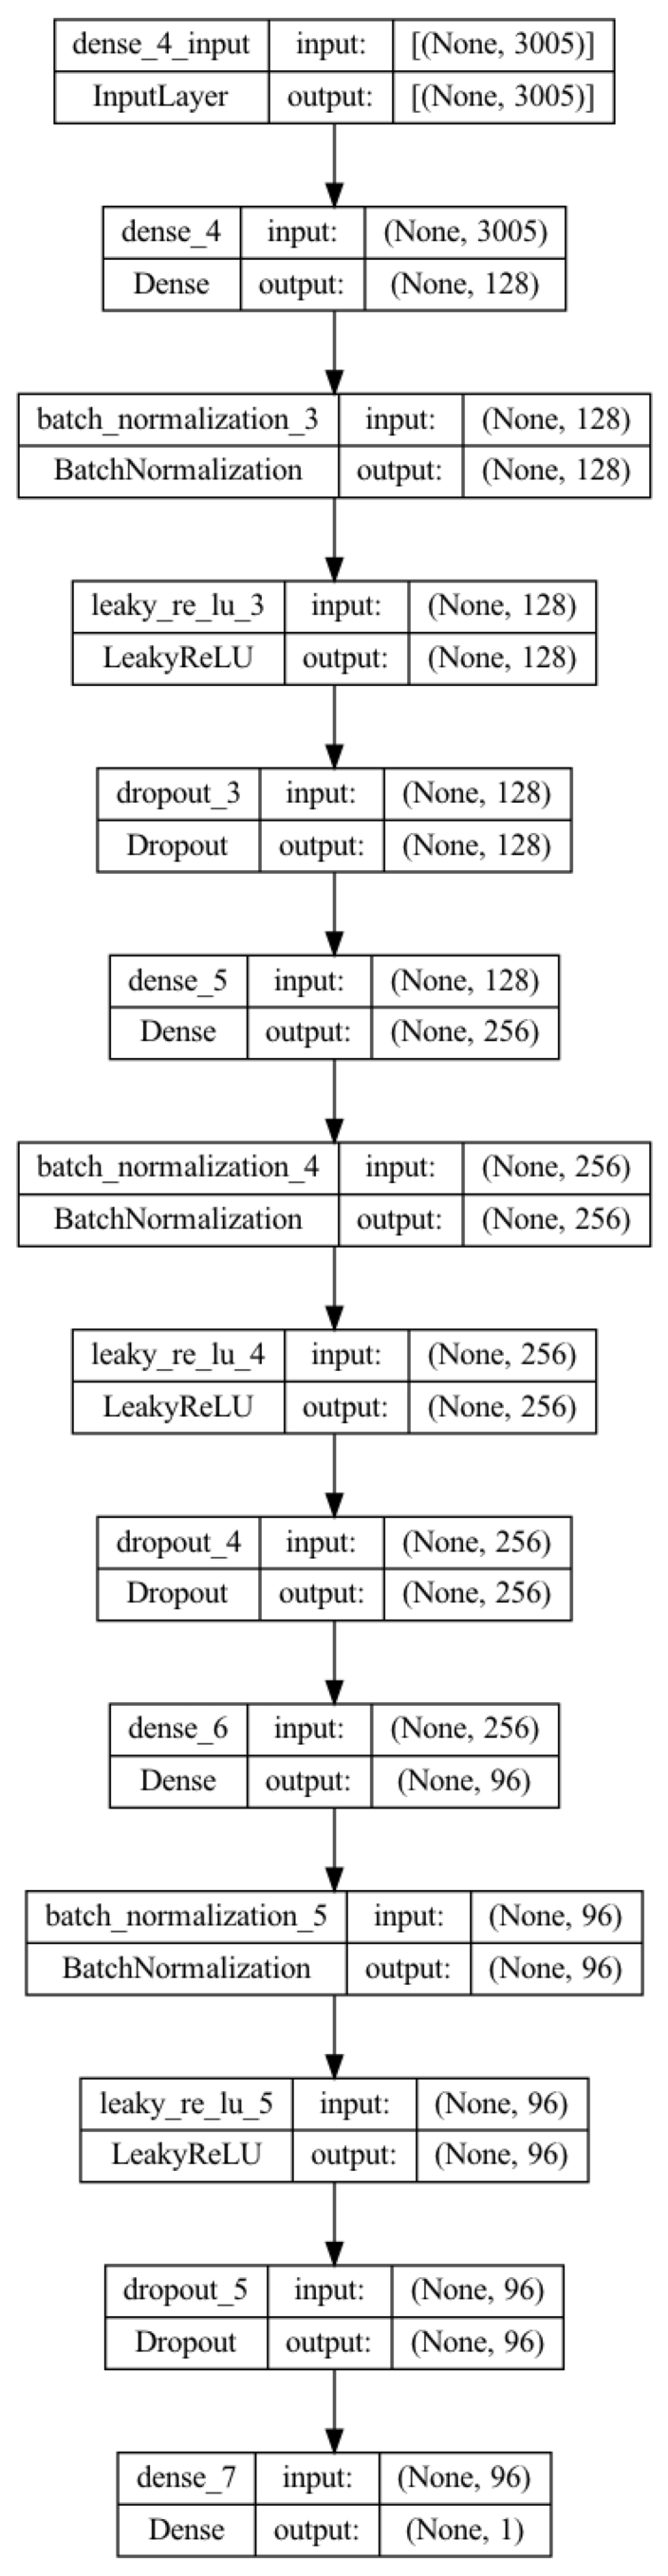

In [16]:
# Display the model structure image
plt.figure(figsize=(10, 35))
img = plt.imread('model_structure.png')
plt.imshow(img)
plt.axis('off')
plt.show()